In [55]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
import os
from dotenv import load_dotenv

In [56]:
load_dotenv()

True

In [57]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [58]:
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.5,
    max_retries=2,
)

In [59]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 42, 'total_tokens': 50, 'completion_time': 0.01162096, 'prompt_time': 0.0023011, 'queue_time': 0.05338474, 'total_time': 0.01392206}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run-13bf7c23-1334-4bb4-b2cd-0a0a5029e5ec-0', usage_metadata={'input_tokens': 42, 'output_tokens': 8, 'total_tokens': 50})

In [60]:
# Define GraphState
class GraphState(TypedDict):
    application: str
    experience_level: str
    skill_match: str
    response: str

In [61]:
workflow = StateGraph(GraphState)

In [62]:
def categorize_experience(state: GraphState) -> GraphState:
    print("\n Categorizing experience level of candidate")
    prompt = ChatPromptTemplate.from_template(
        "Based on the following Job Application, categorize the candidate as 'Entry Level', 'Mid Level' or 'Senior Level' "
        "Application: {application}")
    
    chain = prompt | llm
    experience_level = chain.invoke({"application":state["application"]}).content
    return {"experience_level": experience_level}

In [63]:
def assess_skills(state: GraphState) -> GraphState:
    """Assess the skills of the candidate"""
    prompt = ChatPromptTemplate.from_template(
        "Based on the Job Application for a Python Developer, assess the candidate's skillset"
        "Respond with either 'Match' or 'No Match'"
        "Application: {application}")
    
    chain = prompt | llm
    skill_match = chain.invoke({"application":state["application"]}).content
    return {"skill_match": skill_match}

In [64]:
def schedule_interview(state: GraphState) -> GraphState:
    """Schedule an interview with a candidate."""
    print("\n Scheduling interview with candidate")
    return {'response' : 'Candidate has been shortlisted for an interview'}


def escalate_to_recruiter(state: GraphState) -> GraphState:
    """Escalate to a recruiter."""
    print("\n Escalating to a recruiter")
    return {'response' : 'Candidate has been escalated to a recruiter'}

def reject_application(state: GraphState) -> GraphState:
    """Reject the application."""
    print("\n Rejecting application")
    return {'response' : 'Candidate has been rejected'}

In [65]:
workflow.add_node(
    "categorize_experience",
    categorize_experience,
)

workflow.add_node(
    "assess_skillset",
    assess_skills,
)

workflow.add_node(
    "schedule_interview",
    schedule_interview,
)

workflow.add_node(
    "escalate_to_recruiter",
    escalate_to_recruiter,
)

workflow.add_node(
    "reject_application",
    reject_application,
)

In [66]:
def route_func(state: GraphState) -> str:
    """Route function for the graph state machine."""
    if(state['skill_match'] == 'Match'):
        return 'schedule_interview'
    elif(state['experience_level'] == 'Senior Level'):
        return 'escalate_to_recruiter'
    else:
        return 'reject_application'

In [67]:
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges("assess_skillset",route_func)

In [68]:
workflow.add_edge(START, "categorize_experience")
workflow.add_edge("assess_skillset", END)
workflow.add_edge("schedule_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)

In [69]:
app = workflow.compile()

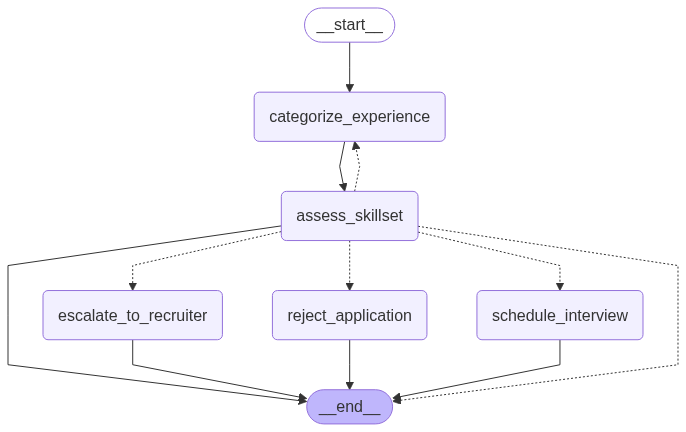

In [70]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [71]:
def run_candidate_screening(application: str):
    results = app.invoke({"application": application})
    return {
        "application": application,
        "experience_level": results["experience_level"],
        "skill_match": results["skill_match"],
        "response": results["response"]
    }

In [72]:
application_text = "I have 10 years of experience as a Python Developer and I can write clean code."
results = run_candidate_screening(application_text)
print(results)


 Categorizing experience level of candidate

 Scheduling interview with candidate
{'application': 'I have 10 years of experience as a Python Developer and I can write clean code.', 'experience_level': "Based on the provided information, I would categorize the candidate as 'Senior Level'. \n\nThe candidate has 10 years of experience as a Python Developer, which suggests a high level of expertise and maturity in their field. Typically, senior-level positions require at least 8-10 years of experience, and the candidate meets this criterion.", 'skill_match': 'Match', 'response': 'Candidate has been shortlisted for an interview'}
